In [29]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import empyrical as empy


In [30]:
start = '1985'
end = '2021'
price_file = './data/XAU_USD.csv'

In [31]:
# pred_nset_csv = 'output_others/20220428/pred_top_tmp2.csv'
# pred_voted_csv = 'output_others/20220428/pred_vote_crossema_4xgb.csv'

pred_nset_csv = 'output_others/20220428/pred_top_tmp3.csv'
pred_voted_csv = 'output_others/20220428/pred_vote_crossema_6xgb.csv'



In [32]:
def predict_freq(pred, freq='M'):
    
    idx = pred.index.to_series()
    idx_m = idx.groupby(pd.Grouper(freq=freq)).first()
    pred_m = pred.groupby(pd.Grouper(freq=freq)).first()
    pred_m.index = idx_m
    pred_m = pred_m.dropna().reindex(idx).ffill()
    
    return pred_m
    

In [33]:
def drawdown_from_price(price):
    if isinstance(price, pd.Series):
        return _drawdown_from_price(price)
    elif isinstance(price, pd.DataFrame):
        return price.apply(_drawdown_from_price)
    else:
        raise non_pd_error

def _drawdown_from_price(price):
    shift_max = price.copy()
    _max = price.iloc[0]
    for i, j in price.items():
        #print('i', i)
        #print('j', j)
        _max = max(_max, j)
        shift_max[i] = _max
    return price / shift_max - 1

def return_to_price(ret, ini=100):
    price_0 = ret.iloc[:1] * 0 + ini
    price_0.index = [0]
    price = (1+ret).cumprod() * ini
    return pd.concat([price_0, price])

def drawdown_from_return(ret, ini=100):
    price = return_to_price(ret, ini)
    return drawdown_from_price(price).iloc[1:]

def avg_drawdown(ret):
    dd = drawdown_from_return(ret)
    return dd.mean()


In [34]:
def empy_metric(ret):
    if isinstance(ret, pd.DataFrame):
        return ret.apply(empy_metric).T
    total_return = lambda x: (1+x).prod()-1
    met_func = [total_return, empy.annual_return, empy.sharpe_ratio, empy.annual_volatility, 
                empy.max_drawdown, avg_drawdown]
    
    met_func_names = ['total_return', 'annual_return', 'sharpe_ratio', 'annual_volatility', 
                      'max_drawdown', 'avg_drawdown',]
    
    se = pd.Series([f(ret) for f in met_func], met_func_names)
    
    se['return/maxdd'] = -se.annual_return/se.max_drawdown
    se['return/avgdd'] = -se.annual_return/se.avg_drawdown
    
    
    return se


In [35]:
price = pd.read_csv(price_file, index_col=0)['adj_close']
price.index = pd.to_datetime(price.index)
price

date
1979-12-27     515.50
1979-12-28     512.00
1980-01-01     512.00
1980-01-02     559.75
1980-01-03     634.25
               ...   
2022-02-04    1807.49
2022-02-07    1820.31
2022-02-08    1825.48
2022-02-09    1832.43
2022-02-10    1834.14
Name: adj_close, Length: 10921, dtype: float64

In [36]:
ret = price.pct_change()
ret = ret[start:end]
ret

date
1985-01-02   -0.009082
1985-01-03   -0.010475
1985-01-04    0.002646
1985-01-07   -0.016166
1985-01-08    0.012743
                ...   
2021-12-27    0.001543
2021-12-28   -0.003054
2021-12-29   -0.000947
2021-12-30    0.006293
2021-12-31    0.007372
Name: adj_close, Length: 9612, dtype: float64

In [37]:
pred_3ema = pd.read_csv('output_all/pred_3ema.csv', index_col=0)
pred_3ema.index = pd.to_datetime(pred_3ema.index)
pred_3ema = pred_3ema[start:end]
pred_3ema

,cross_3ema
Date,
1985-01-02,0
1985-01-03,0
1985-01-04,0
1985-01-07,0
1985-01-08,0
...,...
2021-12-27,1
2021-12-28,1
2021-12-29,1


In [38]:
pred_xgb = pd.read_csv(pred_nset_csv, index_col=0)
pred_xgb.index = pd.to_datetime(pred_xgb.index)
pred_xgb = pred_xgb[start:end]
#pred_xgb = pred_xgb[['y_pred']]
#pred_xgb.columns = ['pred_xgb']
display(pred_xgb.columns)
display(pred_xgb)


Index(['pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))',
       'pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross))',
       'pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel)))',
       'pp21=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel)))',
       'pp5=xgbc((XAU_USD+XAU_AUD+XAU_CNY+XAU_EUR+XAU_JPY)_(EMA_return_all_1_34))',
       'pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(pca(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross)))'],
      dtype='object')

,pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel)),pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross)),pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))),pp21=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))),pp5=xgbc((XAU_USD+XAU_AUD+XAU_CNY+XAU_EUR+XAU_JPY)_(EMA_return_all_1_34)),pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(pca(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross)))
date,,,,,,
1985-01-02,1.0,1.0,0.0,0.0,1.0,1.0
1985-01-03,1.0,1.0,0.0,0.0,1.0,0.0
1985-01-04,1.0,1.0,0.0,0.0,1.0,0.0
1985-01-07,1.0,1.0,0.0,0.0,1.0,1.0
1985-01-08,1.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...
2021-12-27,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-28,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-29,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
pred_base = pd.concat([pred_3ema,pred_xgb], 1).fillna(1)
pred_AND = 1*pred_base.all(1).rename('pred_AND')
pred_OR = 1*pred_base.any(1).rename('pred_OR')
pred_mean = pred_base.mean(1).rename('pred_mean')
pred_vote = pred_mean.apply(lambda x: 0 if x<0.5 else 1).rename('pred_vote')
pred_base_all = pd.concat([pred_base, pred_AND, pred_OR, pred_mean, pred_vote], 1)
#pred_base_all.columns = ['pred_3ema','pred_xgb','pred_AND','pred_OR','pred_mean']
pred_base_all

,cross_3ema,pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel)),pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross)),pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))),pp21=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))),pp5=xgbc((XAU_USD+XAU_AUD+XAU_CNY+XAU_EUR+XAU_JPY)_(EMA_return_all_1_34)),pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(pca(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross))),pred_AND,pred_OR,pred_mean,pred_vote
1985-01-02,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0,1,0.571429,1
1985-01-03,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0,1,0.428571,0
1985-01-04,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0,1,0.428571,0
1985-01-07,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0,1,0.571429,1
1985-01-08,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0,1,0.428571,0
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.142857,0
2021-12-28,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.142857,0
2021-12-29,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.142857,0
2021-12-30,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.142857,0


In [40]:
pred_freqM = predict_freq(pred_base)
pred_freqM.columns = pred_freqM.columns.map(lambda x: x+'_freqM')
pred_freqM_AND = pred_freqM.apply(lambda x: x[0] and x[1], 1).rename('pred_freqM_AND')
pred_freqM_OR = pred_freqM.apply(lambda x: x[0] or x[1], 1).rename('pred_freqM_OR')
pred_freqM_mean = pred_freqM.mean(1).rename('pred_freqM_mean')
pred_freqM_vote = pred_freqM_mean.apply(lambda x: 0 if x<0.5 else 1).rename('pred_freqM_vote')

pred_freqM_all = pd.concat([pred_freqM, pred_freqM_AND, pred_freqM_OR, pred_freqM_mean, pred_freqM_vote], 1)
#pred_freqM_all.columns = ['pred_3ema_freqM','pred_xgb_freqM','pred_freqM_AND','pred_freqM_OR','pred_freqM_mean']
pred_freqM_all

,cross_3ema_freqM,pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))_freqM,pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross))_freqM,pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel)))_freqM,pp21=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel)))_freqM,pp5=xgbc((XAU_USD+XAU_AUD+XAU_CNY+XAU_EUR+XAU_JPY)_(EMA_return_all_1_34))_freqM,pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(pca(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross)))_freqM,pred_freqM_AND,pred_freqM_OR,pred_freqM_mean,pred_freqM_vote
1985-01-02,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.571429,1
1985-01-03,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.571429,1
1985-01-04,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.571429,1
1985-01-07,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.571429,1
1985-01-08,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.571429,1
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1
2021-12-28,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1
2021-12-29,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1
2021-12-30,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1


In [41]:
pred_all_1 = (pred_AND*0+1).to_frame()
pred_all_1.columns = ['buy_and_hold']

In [42]:

pred_all = pd.concat([pred_all_1, pred_base_all, pred_freqM_all], 1)
pred_all

,buy_and_hold,cross_3ema,pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel)),pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross)),pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))),pp21=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))),pp5=xgbc((XAU_USD+XAU_AUD+XAU_CNY+XAU_EUR+XAU_JPY)_(EMA_return_all_1_34)),pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(pca(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross))),pred_AND,pred_OR,...,pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))_freqM,pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross))_freqM,pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel)))_freqM,pp21=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel)))_freqM,pp5=xgbc((XAU_USD+XAU_AUD+XAU_CNY+XAU_EUR+XAU_JPY)_(EMA_return_all_1_34))_freqM,pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(pca(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross)))_freqM,pred_freqM_AND,pred_freqM_OR,pred_freqM_mean,pred_freqM_vote
1985-01-02,1,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0,1,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.571429,1
1985-01-03,1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0,1,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.571429,1
1985-01-04,1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0,1,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.571429,1
1985-01-07,1,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0,1,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.571429,1
1985-01-08,1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0,1,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.571429,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1
2021-12-28,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1
2021-12-29,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1
2021-12-30,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1


In [43]:
#pred_all.to_csv('pred_3ema_xgb.csv')

In [44]:
ret_all = pred_all.multiply(ret,0)
ret_all

,buy_and_hold,cross_3ema,pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel)),pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross)),pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))),pp21=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))),pp5=xgbc((XAU_USD+XAU_AUD+XAU_CNY+XAU_EUR+XAU_JPY)_(EMA_return_all_1_34)),pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(pca(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross))),pred_AND,pred_OR,...,pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))_freqM,pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross))_freqM,pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel)))_freqM,pp21=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel)))_freqM,pp5=xgbc((XAU_USD+XAU_AUD+XAU_CNY+XAU_EUR+XAU_JPY)_(EMA_return_all_1_34))_freqM,pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(pca(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross)))_freqM,pred_freqM_AND,pred_freqM_OR,pred_freqM_mean,pred_freqM_vote
1985-01-02,-0.009082,-0.000000,-0.009082,-0.009082,-0.0,-0.0,-0.009082,-0.009082,-0.0,-0.009082,...,-0.009082,-0.009082,-0.000000,-0.000000,-0.009082,-0.009082,-0.000000,-0.009082,-0.005190,-0.009082
1985-01-03,-0.010475,-0.000000,-0.010475,-0.010475,-0.0,-0.0,-0.010475,-0.000000,-0.0,-0.010475,...,-0.010475,-0.010475,-0.000000,-0.000000,-0.010475,-0.010475,-0.000000,-0.010475,-0.005986,-0.010475
1985-01-04,0.002646,0.000000,0.002646,0.002646,0.0,0.0,0.002646,0.000000,0.0,0.002646,...,0.002646,0.002646,0.000000,0.000000,0.002646,0.002646,0.000000,0.002646,0.001512,0.002646
1985-01-07,-0.016166,-0.000000,-0.016166,-0.016166,-0.0,-0.0,-0.016166,-0.016166,-0.0,-0.016166,...,-0.016166,-0.016166,-0.000000,-0.000000,-0.016166,-0.016166,-0.000000,-0.016166,-0.009238,-0.016166
1985-01-08,0.012743,0.000000,0.012743,0.012743,0.0,0.0,0.012743,0.000000,0.0,0.012743,...,0.012743,0.012743,0.000000,0.000000,0.012743,0.012743,0.000000,0.012743,0.007282,0.012743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.001543,0.001543,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.001543,...,0.001543,0.001543,0.001543,0.001543,0.001543,0.001543,0.001543,0.001543,0.001543,0.001543
2021-12-28,-0.003054,-0.003054,-0.000000,-0.000000,-0.0,-0.0,-0.000000,-0.000000,-0.0,-0.003054,...,-0.003054,-0.003054,-0.003054,-0.003054,-0.003054,-0.003054,-0.003054,-0.003054,-0.003054,-0.003054
2021-12-29,-0.000947,-0.000947,-0.000000,-0.000000,-0.0,-0.0,-0.000000,-0.000000,-0.0,-0.000947,...,-0.000947,-0.000947,-0.000947,-0.000947,-0.000947,-0.000947,-0.000947,-0.000947,-0.000947,-0.000947
2021-12-30,0.006293,0.006293,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.006293,...,0.006293,0.006293,0.006293,0.006293,0.006293,0.006293,0.006293,0.006293,0.006293,0.006293


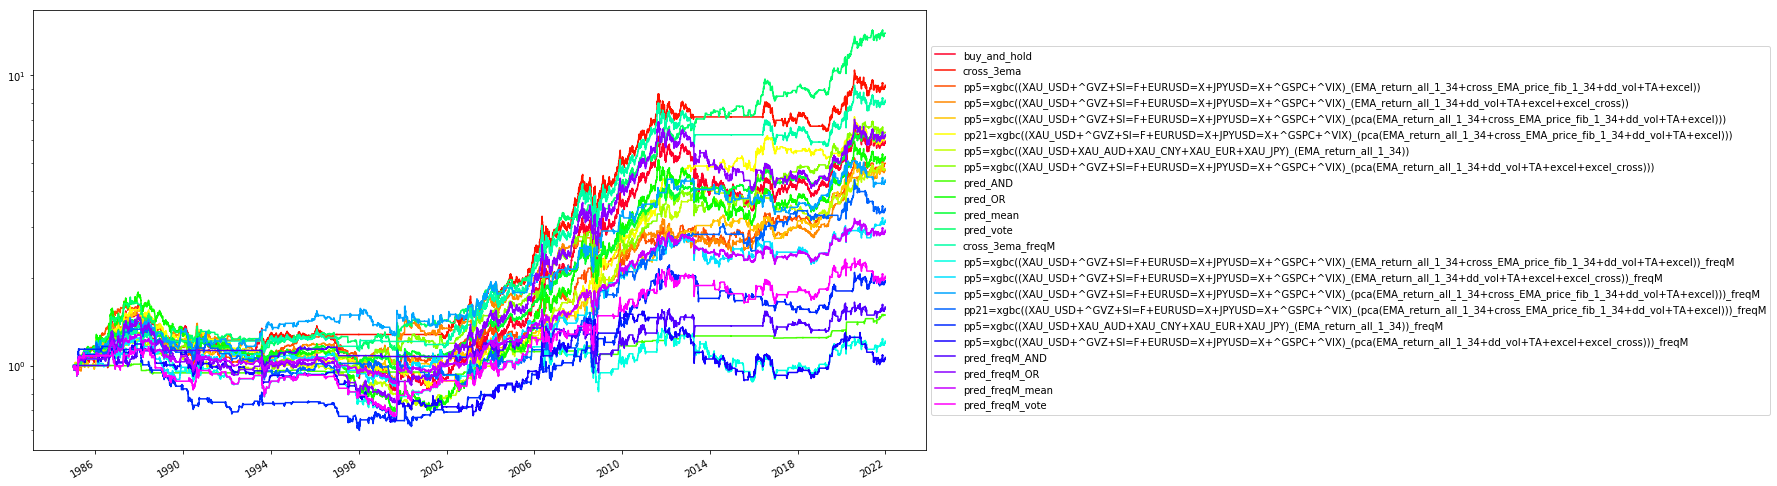

In [45]:

fig, ax = plt.subplots(figsize=(16,9))


cm = plt.get_cmap('gist_rainbow')
NUM_COLORS = ret_all.shape[1]
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])



(1+ret_all).cumprod().plot(ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_yscale("log")
plt.show()

In [46]:
empy_metric(ret_all).sort_values('sharpe_ratio')

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd
pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(pca(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross)))_freqM,0.065751,0.001668,0.069190,0.107303,-0.473445,-0.231792,0.003523,0.007196
pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))_freqM,0.213324,0.005073,0.101755,0.115878,-0.468646,-0.207320,0.010825,0.024471
pred_freqM_AND,0.590916,0.012226,0.175076,0.095897,-0.362607,-0.077660,0.033716,0.157423
pred_freqM_vote,1.029357,0.018694,0.222818,0.110730,-0.427433,-0.153785,0.043736,0.121561
pp5=xgbc((XAU_USD+XAU_AUD+XAU_CNY+XAU_EUR+XAU_JPY)_(EMA_return_all_1_34))_freqM,0.962131,0.017797,0.229444,0.097824,-0.499803,-0.249047,0.035607,0.071459
pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross))_freqM,2.167629,0.030635,0.320968,0.114570,-0.333083,-0.121204,0.091973,0.252753
pp21=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel)))_freqM,2.474702,0.033133,0.349182,0.111127,-0.379275,-0.157582,0.087359,0.210261
pred_freqM_mean,1.923683,0.028475,0.359432,0.089325,-0.324570,-0.128448,0.087732,0.221687
pred_OR,4.242513,0.044314,0.361878,0.151925,-0.612925,-0.277816,0.072299,0.159508
buy_and_hold,4.930555,0.047690,0.378081,0.155384,-0.493126,-0.224901,0.096709,0.212047


In [47]:
empy_met_sort_ret_avgdd = empy_metric(ret_all).sort_values('return/avgdd')
empy_met_sort_ret_avgdd

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd
pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(pca(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross)))_freqM,0.065751,0.001668,0.069190,0.107303,-0.473445,-0.231792,0.003523,0.007196
pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))_freqM,0.213324,0.005073,0.101755,0.115878,-0.468646,-0.207320,0.010825,0.024471
pp5=xgbc((XAU_USD+XAU_AUD+XAU_CNY+XAU_EUR+XAU_JPY)_(EMA_return_all_1_34))_freqM,0.962131,0.017797,0.229444,0.097824,-0.499803,-0.249047,0.035607,0.071459
pred_freqM_vote,1.029357,0.018694,0.222818,0.110730,-0.427433,-0.153785,0.043736,0.121561
pred_freqM_AND,0.590916,0.012226,0.175076,0.095897,-0.362607,-0.077660,0.033716,0.157423
pred_OR,4.242513,0.044314,0.361878,0.151925,-0.612925,-0.277816,0.072299,0.159508
pp21=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel)))_freqM,2.474702,0.033133,0.349182,0.111127,-0.379275,-0.157582,0.087359,0.210261
buy_and_hold,4.930555,0.047690,0.378081,0.155384,-0.493126,-0.224901,0.096709,0.212047
pred_freqM_OR,5.252662,0.049141,0.410340,0.141542,-0.503180,-0.227005,0.097660,0.216475
pred_freqM_mean,1.923683,0.028475,0.359432,0.089325,-0.324570,-0.128448,0.087732,0.221687


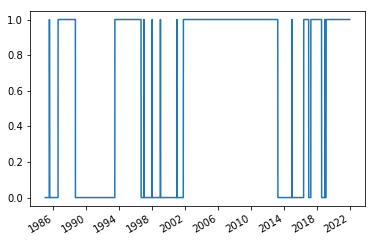

In [48]:
pred_all['cross_3ema'].plot()

In [21]:
pred_all['pp10=xgbc(all_index_(EMA_return_all34+dd_vol))'].plot()

KeyError: 'pp10=xgbc(all_index_(EMA_return_all34+dd_vol))'

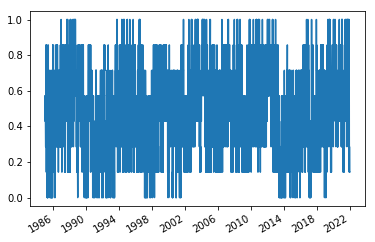

In [49]:
pred_all.pred_mean.plot()

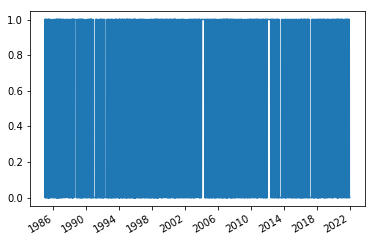

In [50]:
pred_all.pred_vote.plot()

In [51]:
pred_tmp = pred_all[empy_met_sort_ret_avgdd.index]

In [52]:
pred_tmp.mean()

pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(pca(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross)))_freqM                  0.457680
pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))_freqM          0.516045
pp5=xgbc((XAU_USD+XAU_AUD+XAU_CNY+XAU_EUR+XAU_JPY)_(EMA_return_all_1_34))_freqM                                                          0.384775
pred_freqM_vote                                                                                                                          0.467234
pred_freqM_AND                                                                                                                           0.303666
pred_OR                                                                                                                                  0.957836
pp21=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel

In [53]:
(pred_tmp-pred_tmp.shift()).abs().mean()

pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(pca(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross)))_freqM                  0.019734
pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))_freqM          0.020150
pp5=xgbc((XAU_USD+XAU_AUD+XAU_CNY+XAU_EUR+XAU_JPY)_(EMA_return_all_1_34))_freqM                                                          0.017657
pred_freqM_vote                                                                                                                          0.017865
pred_freqM_AND                                                                                                                           0.013191
pred_OR                                                                                                                                  0.031575
pp21=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel

In [54]:
df_tmp = pred_all[['pred_vote','pred_mean']]
df_tmp.columns = ['y_pred','y_prob']
df_tmp

,y_pred,y_prob
1985-01-02,1,0.571429
1985-01-03,0,0.428571
1985-01-04,0,0.428571
1985-01-07,1,0.571429
1985-01-08,0,0.428571
...,...,...
2021-12-27,0,0.142857
2021-12-28,0,0.142857
2021-12-29,0,0.142857
2021-12-30,0,0.142857


In [55]:
df_tmp.to_csv(pred_voted_csv)

In [ ]:
xap = (1+ret_all['pred_vote']).cumprod()*10
xap

In [ ]:
xap_df = pd.concat([xap]*5, 1)
xap_df.columns = ['open','high','low','close','adj_close']
xap_df['code'] = 'AML_XAP'
xap_df.index.name = 'date'
xap_df = xap_df.reset_index().set_index(['date','code'])
xap_df

In [ ]:
#xap_df.to_csv('AML_XAP.csv')